In [1]:
import numpy as np
import torch
from torch import nn
import networkx as nx
import copy

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

MultiDiGraph with 2 nodes and 2 edges
(0, {'type': 'n', 'v': 0})
(1, {'type': 'n', 'v': ''})
(0, 1, {'type': 's', 'v': '', 'i': 1, 'p': ''})
(1, 0, {'type': 'r', 'v': '', 'i': '', 'p': 2})


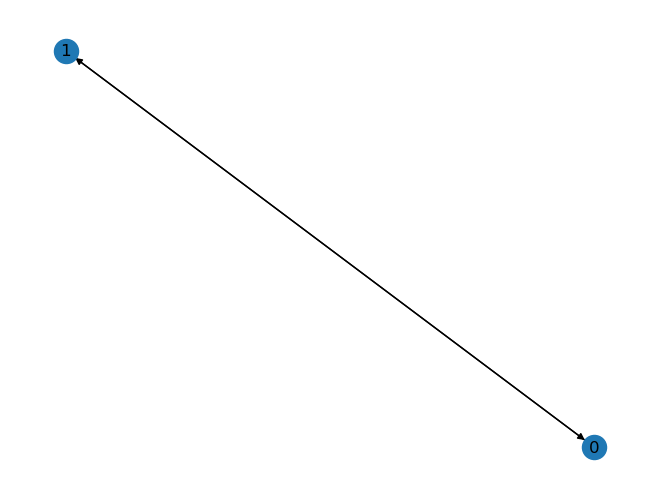

In [3]:
vr = nx.MultiDiGraph()
vr.add_node(0,type='n',v=0)
vr.add_node(1,type='n',v='')
# tail of edge is starting node
# head of edge is ending node
vr.add_edges_from(
        [
            (0,1,{'type':'s','v':'','i':1,'p':''}),
            (1,0,{'type':'r','v':'','i':'','p':2})
        ]
    )
print(vr)
for node in vr.nodes().data():
    print(node)
for edge in vr.edges.data():
    print(edge)
nx.draw(vr,with_labels = True)

# Expected Sizes of Vectors

In [4]:
# create tensors for voltages, currents, and element params
num_elements = vr.number_of_edges()
num_nodes = vr.number_of_nodes()
print(f'size of element currents, voltages, and params = ({num_elements},1)')
print(f'size of node voltages = ({num_nodes},1)')

size of element currents, voltages, and params = (2,1)
size of node voltages = (2,1)


# Extract Circuit Parameters for the Model

In [5]:
def extract(nx_list: list, params_order_map: dict, types_map: dict):
    '''
    input: node or edge list with data from nx graph. Key order is a list of maps 
    from the parameter key to the desired order in the ouput vectors [{str:int}]

    output:  two matrices. 
                params matrix rows are each edge/node of graph.  Columns are
                    each param value corresponding to key order
                knowns matrix rows are each edge/node of graph.  Columns are 
                    boolean of if the param value is known
    '''
    param_matrix = []
    knowns_matrix = []
    type_matrix = []
    num_params = len(next(iter(nx_list))[-1])-1
    num_types = len(types_map)
    print(f'len(key_order_map) = num_params => {len(params_order_map)}, {num_params}' )
    assert(len(params_order_map) == num_params)
    for item in nx_list: # each edge or node
        last_element: dict = item[-1]
        type_oh = [0]*(num_types) # one-hot encoding
        values = [0]*(num_params)
        knowns_oh = [0]*(num_params) # one-hot encoding
        for parameter,value in last_element.items():
            if(parameter == 'type'):
                type_idx = types_map[value]
                type_oh[type_idx] = 1
                continue
            
            idx = params_order_map[parameter]
            if(value==''):
                values[idx] = 0.0
                knowns_oh[idx] = 0
            else:
                values[idx] = float(value)
                knowns_oh[idx] = 1
        param_matrix.append(values)
        knowns_matrix.append(knowns_oh)
        type_matrix.append(type_oh)

    param_matrix = np.array(param_matrix)
    knowns_matrix = np.array(knowns_matrix)
    type_matrix = np.array(type_matrix)
        
    return (type_matrix, param_matrix, knowns_matrix)


In [6]:

node_param_order_map = {'v':0}
types_map = {'n':0,'s':1, 'r':2}
node_types, node_params, node_knowns = extract(vr.nodes().data(), node_param_order_map, types_map)
node_types, node_params, node_knowns

len(key_order_map) = num_params => 1, 1


(array([[1, 0, 0],
        [1, 0, 0]]),
 array([[0.],
        [0.]]),
 array([[1],
        [0]]))

In [7]:
edge_param_order_map = {'v':0, 'i':1, 'p':2}
element_types, element_params, element_knowns = extract(vr.edges.data(), edge_param_order_map, types_map)
element_types, element_params, element_knowns

len(key_order_map) = num_params => 3, 3


(array([[0, 1, 0],
        [0, 0, 1]]),
 array([[0., 1., 0.],
        [0., 0., 2.]]),
 array([[0, 1, 0],
        [0, 0, 1]]))

# Indidence Matrix (KCL loss)

Incidence matrix has rows representing nodes and columns representing edges.

An edge starting and ending node is determined when the edge is created.
Starting node is the "tail".  Ending node is the "head".  Visualize an arrow 
from starting node (tail) to ending node (head).

Matrix entries represent the head and tail connections:

* +1 = head
* -1 = tail

The solutions to the circuit will need to be transformed to make sense with
respect to the original definition of heads and tails.

In [8]:
# generate the incidence matrix and convert to numpy array, then pytorch tensor
M_tensor = nx.incidence_matrix(G=vr,oriented=True)
M_tensor = M_tensor.toarray()
print(f'shape of incidence array = {M_tensor.shape}')
print(M_tensor)

shape of incidence array = (2, 2)
[[-1.  1.]
 [ 1. -1.]]


C:\Users\terry\AppData\Local\Temp\ipykernel_24508\2172744076.py:2: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_tensor = nx.incidence_matrix(G=vr,oriented=True)


Need to create a modified incidence matrix for voltages.  Voltage sources have opposite polarity compared to other elements.  The polarity should go from tail (low potential) to head (high potential) 

In [9]:
types_map['s']

1

In [10]:
element_types[:,types_map['s']]

array([1, 0])

In [11]:
v_source_type_mask = np.zeros_like(M_tensor)
v_source_type_mask += element_types[:,types_map['s']]
v_source_type_mask = v_source_type_mask.astype(bool)
v_source_type_mask

array([[ True, False],
       [ True, False]])

In [12]:
M_tensor[v_source_type_mask]

array([-1.,  1.])

In [13]:
M_tensor_voltage = M_tensor.copy()
M_tensor_voltage[v_source_type_mask] *= -1
M_tensor_voltage

array([[ 1.,  1.],
       [-1., -1.]])

# KVL Matrix

Use minimum spanning tree to find minimum number of voltage loops. Must cast the directional multigraph as undirectional due to missing MST algorithm in MultiDiGraph

In [14]:
# use spanning tree to 
vr_mst = nx.minimum_spanning_tree(nx.MultiGraph(vr))
vr_mst.edges()

MultiEdgeDataView([(0, 1)])

In [15]:
R = nx.difference(vr, vr_mst)
missing_edges = R.edges()
missing_edges

OutMultiEdgeDataView([])

Remove all missing edges from MST from a copy of the directional multigraph

In [16]:
print(vr.edges())
vr_loops = copy.deepcopy(vr)
vr_loops.remove_edges_from(missing_edges)
vr_loops.edges()

[(0, 1), (1, 0)]


OutMultiEdgeDataView([(0, 1), (1, 0)])

In [17]:
loops = []

for missing_edge in missing_edges:
    loop_graph = vr_loops.copy()
    loop_graph.add_edges_from([missing_edge])
    print(loop_graph.edges())
    loops.append(loop_graph)


In [18]:
# loop_graph.edges.data()

# Convert Input Data to Tensors

In [19]:
pot_vector = node_params[:,0].reshape(num_nodes,1)
v_vector = element_params[:,edge_param_order_map['v']].reshape(num_elements,1)
i_vector = element_params[:,edge_param_order_map['i']].reshape(num_elements,1)
param_vector = element_params[:,edge_param_order_map['p']].reshape(num_elements,1)

In [20]:
pot_tensor = torch.tensor(pot_vector,requires_grad=False,dtype=torch.double,device=device)
v_tensor = torch.tensor(v_vector,requires_grad=False,dtype=torch.double,device=device)
i_tensor = torch.tensor(i_vector,requires_grad=False,dtype=torch.double,device=device)
param_tensor = torch.tensor(param_vector,requires_grad=False,dtype=torch.double,device=device)
pot_tensor,v_tensor,i_tensor,param_tensor

(tensor([[0.],
         [0.]], dtype=torch.float64),
 tensor([[0.],
         [0.]], dtype=torch.float64),
 tensor([[1.],
         [0.]], dtype=torch.float64),
 tensor([[0.],
         [2.]], dtype=torch.float64))

# Masks

In [21]:
# knowns masks
pot_mask = node_knowns
v_mask = element_knowns[:,edge_param_order_map['v']].reshape(num_elements,1)
i_mask = element_knowns[:,edge_param_order_map['i']].reshape(num_elements,1)
param_mask = element_knowns[:,edge_param_order_map['p']].reshape(num_elements,1)

pot_mask = torch.tensor(pot_mask,dtype=bool, requires_grad=False,device=device)
v_mask = torch.tensor(v_mask,dtype=bool,requires_grad=False,device=device)
i_mask = torch.tensor(i_mask,dtype=bool,requires_grad=False,device=device)
param_mask = torch.tensor(param_mask,dtype=bool,requires_grad=False,device=device)

pot_mask, v_mask, i_mask, param_mask

(tensor([[ True],
         [False]]),
 tensor([[False],
         [False]]),
 tensor([[ True],
         [False]]),
 tensor([[False],
         [ True]]))

In [22]:
# inverted knowns masks
pot_mask_inv = ~pot_mask
v_mask_inv = ~v_mask
i_mask_inv = ~i_mask
param_mask_inv = ~param_mask

pot_mask_inv, v_mask_inv, i_mask_inv, param_mask_inv

(tensor([[False],
         [ True]]),
 tensor([[True],
         [True]]),
 tensor([[False],
         [ True]]),
 tensor([[ True],
         [False]]))

In [23]:
param_tensor[param_mask_inv]

tensor([0.], dtype=torch.float64)

In [24]:
# resistor device equation
resistor_mask = torch.tensor(element_types[:,types_map['r']],requires_grad=False,dtype=torch.bool,device=device)
resistor_mask = resistor_mask.reshape(num_elements,1)
resistor_mask

tensor([[False],
        [ True]])

In [25]:
# source device equation
source_mask = torch.tensor(element_types[:,types_map['s']],requires_grad=False,dtype=torch.double,device=device)
source_mask = source_mask.reshape(num_elements,1)
source_mask

tensor([[1.],
        [0.]], dtype=torch.float64)

In [26]:
resistor_func = i_tensor * param_tensor - v_tensor
resistor_func

tensor([[0.],
        [0.]], dtype=torch.float64)

In [27]:
masked_resistor = resistor_func * resistor_mask
masked_resistor

tensor([[0.],
        [0.]], dtype=torch.float64)

In [28]:
i_tensor * param_tensor - v_tensor

tensor([[0.],
        [0.]], dtype=torch.float64)

# Circuit Theory Functions

In [29]:
M_tensor = torch.tensor(M_tensor,requires_grad=True,dtype=torch.double,device=device)
M_tensor

tensor([[-1.,  1.],
        [ 1., -1.]], dtype=torch.float64, requires_grad=True)

In [30]:
M_tensor_voltage = torch.tensor(M_tensor_voltage,requires_grad=True,dtype=torch.double,device=device)
M_tensor_voltage

tensor([[ 1.,  1.],
        [-1., -1.]], dtype=torch.float64, requires_grad=True)

# Models

In [31]:
class Normalize(nn.Module):
    def __init__(self):
        super().__init__()
 
    def forward(self, input, max, min, eps = 1e-12):
        ''' 
        normalize input tensor elementwise
        '''
        # x = input - mean
        # x = x / (std + eps)
        x = input / (max - min + eps)
        return x

In [32]:
class KCL_error(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, M_tensor, i_tensor):
        return M_tensor @ i_tensor

In [33]:
class KVL(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, M_tensor, pot_tensor):
        ''' 
        returns the voltage tensor that satisfies KVL using the matrix 
        multiplication of the incidence matrix (transposed) and the potentials
        vector
        eps is 'epsilon', a tiny constant to prevent divide by zero error
        '''
        return M_tensor.T @ pot_tensor

In [34]:
class KVL_error(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, M_tensor, pot_tensor, voltage_tensor):
        ''' 
        returns the loss between voltage tensor calculated voltages via KVL
        vector
        '''
        return M_tensor.T @ pot_tensor - voltage_tensor

In [35]:
class Resistor(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, i_tensor, v_tensor, param_tensor):
        return i_tensor * param_tensor - v_tensor

In [36]:
class Resistor_V(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, i_tensor, v_tensor, param_tensor):
        return i_tensor * param_tensor - v_tensor

In [37]:
class Resistor_I(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, v_tensor, i_tensor, param_tensor, eps = 1e-12):
        return v_tensor / (param_tensor + eps) - i_tensor

In [38]:
class Combine(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, a, a_mask, b, b_mask):
        '''
        a_mask is True when element in b is a known.
        b_mask is True when element in b is relevant to a.
        Add relevant elements from b to unknown elements in a
        '''
        # print(f'a = {a}')
        # print(f'a_mask = {a_mask}')
        # print(f'b = {b}')
        # print(f'b_mask = {b_mask}')
        a_mask_inv = ~a_mask
        # print(f'a_mask_inv = {a_mask_inv}')
        # only have b with non zero entries if relevant and fill unknowns in 'a'
        b = b * a_mask_inv  # zero out spots in be to avoid adding to knowns in 'a'
        b = b * b_mask # zero out the non-relevant fields 'b'
        #zero out the mirror fields in 'a' to be added by 'b'
        b_mask_inv = ~b_mask
        # print(f'b_mask_inv = {b_mask_inv}')
        a = a * b_mask_inv  # zero out relevant spots
        a = a * a_mask # zero out the unknowns
        return a + b

In [39]:
# class Source(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, v_tensor, param_tensor, source_mask):
#         # zero out non-sources
#         source_func = v_tensor - param_tensor
#         masked_resistor = resistor_func * source_mask
#         return masked_resistor

In [40]:
# Define model
class Solver(nn.Module):
    def __init__(self):
        super().__init__()
        # inputs with randomized unknowns
        self.M = M_tensor # no unknowns
        self.pot = nn.Parameter(pot_tensor + torch.rand_like(pot_tensor) * pot_mask_inv)
        self.v = nn.Parameter(v_tensor + torch.rand_like(v_tensor) * v_mask_inv)
        self.i = nn.Parameter(i_tensor + torch.rand_like(i_tensor) * i_mask_inv)
        self.param = nn.Parameter(param_tensor + torch.rand_like(param_tensor) * param_mask_inv)

        # declare custom modules
        self.kcl_error = KCL_error()
        self.kvl = KVL()
        self.resistor = Resistor()
        self.norm = Normalize()
        self.resistor_v = Resistor_V()
        self.resistor_i = Resistor_I()
        self.combine = Combine()
        self.kvl_error = KVL_error()

    def forward(self): # no "x" or other inputs because no inference mode
        # KVL loss
        voltage_error = self.kvl_error(self.M, self.pot, self.v)
                
        # element equations mapping voltage -> current
        element_error = self.resistor(  self.i[resistor_mask], 
                                        self.v[resistor_mask], 
                                        self.param[resistor_mask])

        # KCL loss
        current_error = self.kcl_error(self.M, self.i)

        # return torch.cat(tensors=(current_error, voltage_error))
        return current_error, voltage_error, element_error#element_error_i, element_error_v

model = Solver().to(device)
print(model)

Solver(
  (kcl_error): KCL_error()
  (kvl): KVL()
  (resistor): Resistor()
  (norm): Normalize()
  (resistor_v): Resistor_V()
  (resistor_i): Resistor_I()
  (combine): Combine()
  (kvl_error): KVL_error()
)


# Loss

In [41]:
loss_fn = nn.MSELoss()

# Optimizer

In [42]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.1)

# Train Function

The key to making it work consistently is separating the losses by equation that 
is being solved: kvl, kcl, elements, etc.  However, it struggles with large
differences in values (1 vs 100 Ohms in the same circuit).  Needs some form of 
normalization.

In [43]:
def train(model, loss_fn, optimizer):
    model.train()
    
    for i in range(4):
        # Compute prediction error
        kcl_pred, kvl_pred, element_pred = model() # model takes no inputs
        # kcl_pred, kvl_pred, element_pred_i, element_pred_v = model() # model takes no inputs
        kcl_loss = loss_fn(kcl_pred, torch.zeros_like(kcl_pred))
        kvl_loss = loss_fn(kvl_pred, torch.zeros_like(kvl_pred))
        element_loss = loss_fn(element_pred, torch.zeros_like(element_pred))
        # element_loss_i = loss_fn(element_pred_i, torch.zeros_like(element_pred_i))
        # element_loss_v = loss_fn(element_pred_v, torch.zeros_like(element_pred_v))
        
        # zero out the cached set of gradients from previous backprop
        optimizer.zero_grad()

        # Backpropagation to produce gradients
        kcl_loss.backward()
        kvl_loss.backward()
        element_loss.backward()

        # freeze parameters that are known circuit attributes before stepping optimizer
        if(0 <= i < 1):
            model.pot.grad = torch.zeros_like(model.pot.grad)
        else:
            model.pot.grad[pot_mask] = 0

        if(1 <= i < 2):
            model.v.grad = torch.zeros_like(model.v.grad)
        else:
            model.v.grad[v_mask] = 0

        if(2 <= i < 3):
            model.i.grad = torch.zeros_like(model.i.grad)
        else:
            model.i.grad[i_mask] = 0

        if(3 <= i < 4):
            model.param.grad = torch.zeros_like(model.param.grad)
        else:
            model.param.grad[param_mask] = 0
        
        # update the model parameters with gradients
        optimizer.step()

    return kcl_loss, kvl_loss, element_loss

# Test Function 

No inference therefore no testing!

# Run Train Loop

In [44]:
epochs = 1000

total_loss = 0
prev_loss = 0.1
lt_prev_loss = 1000

for t in range(epochs):
    kcl_loss,kvl_loss,element_loss = train(model, loss_fn, optimizer)
    max_loss = max(kcl_loss, kvl_loss, element_loss)
    loss_change = abs(max_loss - prev_loss) / prev_loss
    prev_loss = max_loss        

    if (t % (epochs/10)) == 0:
        print(f'epoch {t} loss = {max_loss} ({loss_change} per unit change)')
        if max_loss > lt_prev_loss:
            for g in optimizer.param_groups:
                g['lr'] /= 10
            print(f'reducing learning rate')
        lt_prev_loss = max_loss

    if max_loss < 1e-10:
        print(f'epoch {t} loss = {max_loss} finished early for loss threshold')
        break

print("Done!")
print(f'potentials = {model.pot}')
print(f'voltages = {model.v}')
print(f'currents = {model.i}')
print(f'parameters = {model.param}')

epoch 0 loss = 0.701926325952714 (6.01926325952714 per unit change)
epoch 53 loss = 4.12435672948054e-11 finished early for loss threshold
Done!
potentials = Parameter containing:
tensor([[ 0.0000],
        [-2.0000]], dtype=torch.float64, requires_grad=True)
voltages = Parameter containing:
tensor([[-2.0000],
        [ 2.0000]], dtype=torch.float64, requires_grad=True)
currents = Parameter containing:
tensor([[1.0000],
        [1.0000]], dtype=torch.float64, requires_grad=True)
parameters = Parameter containing:
tensor([[0.6319],
        [2.0000]], dtype=torch.float64, requires_grad=True)
